# 0.2.0 Spatial relationships

In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

import contextily

import geopandas as gpd 
from shapely.geometry import Point

import mapclassify

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("../../") 

import utils.paths as path
from utils.paths2 import direcciones

In [4]:
districts = gpd.read_file(path.data_raw_dir("working/paris_districts_utm.geojson"))
districts.geometry = districts.geometry.to_crs(epsg = 3857)
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((260998.942 6250132.905, 260998.863 6..."
1,2,Halles,8984,"POLYGON ((261530.205 6251237.030, 261402.637 6..."
2,3,Palais-Royal,3195,"POLYGON ((260428.149 6251500.935, 260390.032 6..."
3,4,Place-Vendôme,3044,"POLYGON ((259590.927 6251970.939, 259525.101 6..."
4,5,Gaillon,1345,"POLYGON ((260077.976 6252488.522, 260027.754 6..."


In [5]:
# Read the restaurants csv file into a DataFrame
df = pd.read_csv(path.data_raw_dir("working/paris_restaurants.csv"))

# Convert it to a GeoDataFrame
restaurants = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

## 0.2.2 Creating a Point geometry

In [6]:
# Construct a point object for the Eiffel Tower
eiffel_tower = Point(255422.6, 6250868.9)

# Print the result
print(eiffel_tower)

POINT (255422.6 6250868.9)


## 0.2.3 Shapely's spatial methods

In [7]:
# Construct a point object for the Eiffel Tower
eiffel_tower = Point(255422.6, 6250868.9)

# Accessing the Montparnasse geometry (Polygon) and restaurant
district_montparnasse = districts.loc[52, 'geometry']
resto = restaurants.loc[956, 'geometry']

In [8]:
# Is the Eiffel Tower located within the Montparnasse district?
print(eiffel_tower.within(district_montparnasse))

# Does the Montparnasse district contains the restaurant?
print(district_montparnasse.contains(resto))

# The distance between the Eiffel Tower and the restaurant?
print(eiffel_tower.distance(resto))

False
True
4431.459825587062


## 0.2.5 In which district in the Eiffel Tower located?

In [9]:
# Construct a point object for the Eiffel Tower
eiffel_tower = Point(255422.6, 6250868.9)

# Create a boolean Series
mask = districts.contains(eiffel_tower)

# Print the boolean Series
print(mask.head())

0    False
1    False
2    False
3    False
4    False
dtype: bool


In [10]:
# Filter the districts with the boolean mask
print(districts[mask])

    id district_name  population  \
27  28  Gros-Caillou       25156   

                                             geometry  
27  POLYGON ((257097.290 6250116.967, 256754.256 6...  


## 0.2.6 How far is the closest restaurant?

In [12]:
# The distance from each restaurant to the Eiffel Tower
dist_eiffel = restaurants.distance(eiffel_tower)

In [13]:
# The distance to the closest restaurant
print(dist_eiffel.min())

460.69760282781715


In [14]:
# Filter the restaurants for closer than 1 km
restaurants_eiffel = restaurants[dist_eiffel < 1000]

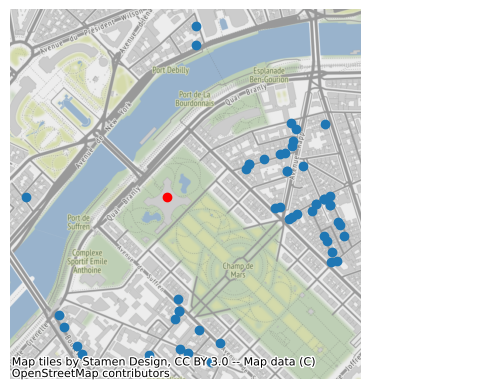

In [17]:
# Make a plot of the close-by restaurants
ax = restaurants_eiffel.plot()
gpd.GeoSeries([eiffel_tower]).plot(ax=ax, color='red')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

## 0.2.8 Paris: spatial join of districts and bike stations

In [18]:
stations = gpd.read_file(path.data_raw_dir("working/paris_sharing_bike_stations_utm.geojson"))
stations.geometry = stations.geometry.to_crs(epsg = 3857)
stations.head()

,name,bike_stands,available_bikes,geometry
0,14002 - RASPAIL QUINET,44,4,POINT (259324.887 6247620.771)
1,20503 - COURS DE VINCENNES PYRÉNÉES,21,3,POINT (267824.377 6249062.894)
2,20011 - PYRÉNÉES-DAGORNO,21,0,POINT (267742.135 6250378.469)
3,31008 - VINCENNES (MONTREUIL),56,0,POINT (271326.638 6250750.824)
4,43006 - MINIMES (VINCENNES),28,27,POINT (270594.689 6248007.705)


In [19]:
stations.shape

(1226, 4)

In [20]:
# Join the districts and stations datasets
joined = gpd.sjoin(stations, districts, op = 'within')

# Inspect the first five rows of the result
print(joined.head())

                                       name  bike_stands  available_bikes  \
0                    14002 - RASPAIL QUINET           44                4   
143  14112 - FAUBOURG SAINT JACQUES CASSINI           16                0   
293               14033 - DAGUERRE GASSENDI           38                1   
346     14006 - SAINT JACQUES TOMBE ISSOIRE           22                0   
429       14111 - DENFERT-ROCHEREAU CASSINI           24                8   

                           geometry  index_right  id district_name  population  
0    POINT (259324.887 6247620.771)           52  53  Montparnasse       18570  
143  POINT (260262.781 6247057.330)           52  53  Montparnasse       18570  
293  POINT (259184.149 6247025.657)           52  53  Montparnasse       18570  
346  POINT (260146.235 6246604.533)           52  53  Montparnasse       18570  
429  POINT (260040.441 6247341.726)           52  53  Montparnasse       18570  


## 0.2.9 Map of tree density by district (1)

In [24]:
# Read the trees and districts data
trees = gpd.read_file(path.data_raw_dir("working/paris_trees_small.gpkg"))
trees.geometry = trees.geometry.to_crs(epsg = 3857)
trees.head()

,species,location_type,geometry
0,Marronnier,Alignement,POINT (266943.038 6249180.953)
1,Marronnier,Alignement,POINT (252825.076 6251787.771)
2,Marronnier,Alignement,POINT (257751.975 6247727.367)
3,Marronnier,Alignement,POINT (260810.948 6246865.138)
4,Sophora,Alignement,POINT (253617.023 6247506.702)


In [25]:
districts = gpd.read_file(path.data_raw_dir("working/paris_districts_utm.geojson"))
districts.geometry = districts.geometry.to_crs(epsg = 3857)
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((260998.942 6250132.905, 260998.863 6..."
1,2,Halles,8984,"POLYGON ((261530.205 6251237.030, 261402.637 6..."
2,3,Palais-Royal,3195,"POLYGON ((260428.149 6251500.935, 260390.032 6..."
3,4,Place-Vendôme,3044,"POLYGON ((259590.927 6251970.939, 259525.101 6..."
4,5,Gaillon,1345,"POLYGON ((260077.976 6252488.522, 260027.754 6..."


In [26]:
# Spatial join of the trees and districts datasets
joined = gpd.sjoin(trees, districts, op = 'within')

# Inspect the first five rows of the result
print(joined.head())

         species location_type                        geometry  index_right  \
0     Marronnier    Alignement  POINT (266943.038 6249180.953)           43   
130  Micocoulier    Alignement  POINT (266367.230 6249982.706)           43   
142      Platane    Alignement  POINT (266744.107 6249499.656)           43   
402      Cedrele    Alignement  POINT (266490.070 6249682.153)           43   
428  Micocoulier    Alignement  POINT (266411.100 6249945.648)           43   

     id      district_name  population  
0    44  Sainte-Marguerite       36476  
130  44  Sainte-Marguerite       36476  
142  44  Sainte-Marguerite       36476  
402  44  Sainte-Marguerite       36476  
428  44  Sainte-Marguerite       36476  


In [27]:
# Calculate the number of trees in each district
trees_by_district = joined.groupby('district_name').size()

# Convert the series to a DataFrame and specify column name
trees_by_district = trees_by_district.to_frame(name='n_trees')

# Inspect the result
print(trees_by_district.head())

                 n_trees
district_name           
Amérique             183
Archives               8
Arsenal               60
Arts-et-Metiers       20
Auteuil              392


## 0.2.10 Map of tree density by district (2)

In [28]:
# Print the first rows of the result of the previous exercise
print(trees_by_district.head())

                 n_trees
district_name           
Amérique             183
Archives               8
Arsenal               60
Arts-et-Metiers       20
Auteuil              392


In [31]:
# Merge the 'districts' and 'trees_by_district' dataframes
districts_trees = pd.merge(districts, trees_by_district, on='district_name')

# Inspect the result
print(districts_trees.head())

   id           district_name  population  \
0   1  St-Germain-l'Auxerrois        1672   
1   2                  Halles        8984   
2   3            Palais-Royal        3195   
3   4           Place-Vendôme        3044   
4   5                 Gaillon        1345   

                                            geometry  n_trees  
0  POLYGON ((260998.942 6250132.905, 260998.863 6...       40  
1  POLYGON ((261530.205 6251237.030, 261402.637 6...       40  
2  POLYGON ((260428.149 6251500.935, 260390.032 6...        4  
3  POLYGON ((259590.927 6251970.939, 259525.101 6...        7  
4  POLYGON ((260077.976 6252488.522, 260027.754 6...        7  


In [33]:
# Add a column with the tree density
districts_trees['n_trees_per_area'] = districts_trees['n_trees']/districts_trees.area

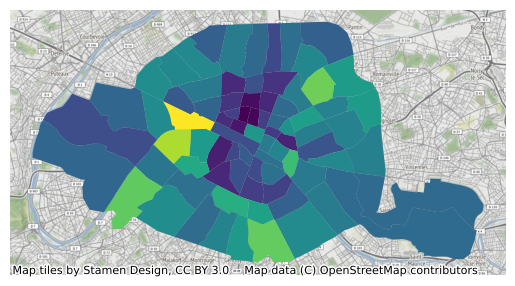

In [38]:
# Make of map of the districts colored by 'n_trees_per_area'
ax = districts_trees.plot(column = 'n_trees_per_area')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

## 0.2.12 Equal interval choropleth

In [39]:
# Print the first rows of the tree density dataset
print(districts_trees.head())

   id           district_name  population  \
0   1  St-Germain-l'Auxerrois        1672   
1   2                  Halles        8984   
2   3            Palais-Royal        3195   
3   4           Place-Vendôme        3044   
4   5                 Gaillon        1345   

                                            geometry  n_trees  \
0  POLYGON ((260998.942 6250132.905, 260998.863 6...       40   
1  POLYGON ((261530.205 6251237.030, 261402.637 6...       40   
2  POLYGON ((260428.149 6251500.935, 260390.032 6...        4   
3  POLYGON ((259590.927 6251970.939, 259525.101 6...        7   
4  POLYGON ((260077.976 6252488.522, 260027.754 6...        7   

   n_trees_per_area  
0          0.000020  
1          0.000042  
2          0.000006  
3          0.000011  
4          0.000016  


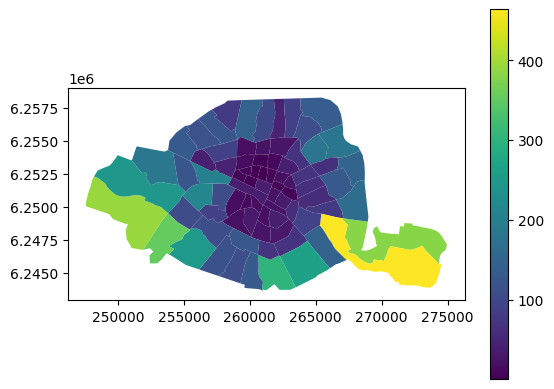

In [40]:
# Make a choropleth of the number of trees 
districts_trees.plot(column='n_trees', legend=True)
plt.show()

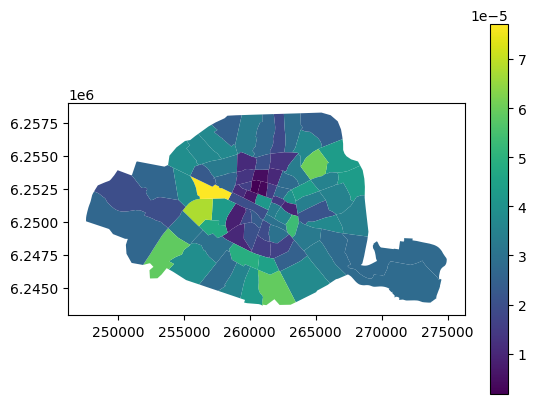

In [41]:
# Make a choropleth of the number of trees per area
districts_trees.plot(column='n_trees_per_area', legend=True)
plt.show()

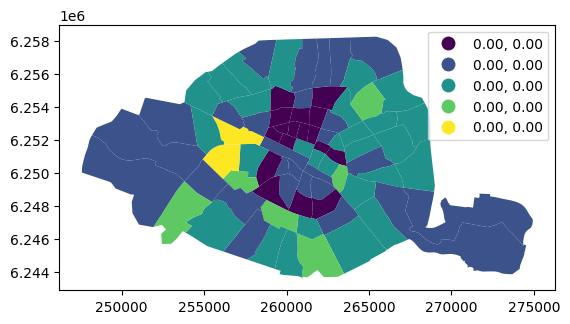

In [48]:
# Make a choropleth of the number of trees 
districts_trees.plot(column='n_trees_per_area', scheme='equal_interval', legend=True)
plt.show()

## 0.2.13 Quantiles choropleth

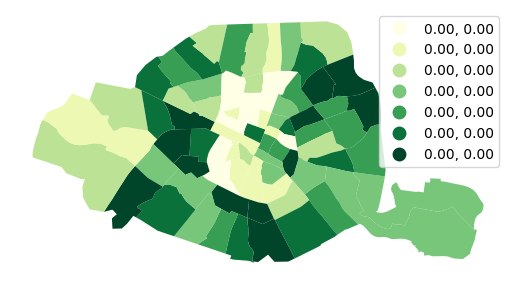

In [47]:
# Generate the choropleth and store the axis
ax = districts_trees.plot(column='n_trees_per_area', scheme='quantiles', k=7, cmap='YlGn', legend=True)

# Remove frames, ticks and tick labels from the axis
ax.set_axis_off()
plt.show()

## 0.2.14 Compare classification algorithms

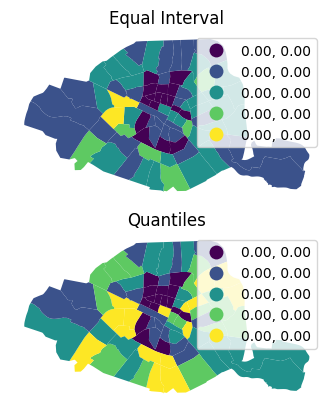

In [49]:
# Set up figure and subplots
fig, axes = plt.subplots(nrows=2)

# Plot equal interval map
districts_trees.plot(column='n_trees_per_area', scheme='equal_interval', k=5, legend=True, ax=axes[0])
axes[0].set_title('Equal Interval')
axes[0].set_axis_off()

# Plot quantiles map
districts_trees.plot(column='n_trees_per_area', scheme='quantiles', k=5, legend=True, ax=axes[1])
axes[1].set_title('Quantiles')
axes[1].set_axis_off()

# Display maps
plt.show()

In [11]:
print('ok_')

ok_
